# Analysing multigrid approach with fast_tsne implementation for tasic data

In [1]:
from time import time
from datetime import datetime
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist
from scipy.stats import spearmanr
from scipy import sparse

import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd
import pickle
import seaborn as sns

# sys.path.append(os.path.abspath("."))  # add src/ to path
# from utils.load_dataset import get_mnist, get_fmnist, get_tasic2018

sys.path.insert(0, r"C:\Users\arsla\my_files\research_project\mg-emb-exps-main-KB\mg-emb-exps-main-KB")
from src.utils.load_dataset import get_mnist, get_fmnist, load_flow18, load_wong, load_celegans, get_tasic2018
from src.utils import rnaseqTools

# the path should point to the FIt-SNE directory
sys.path.append('../FIt-SNE')
from fast_tsne import fast_tsne

### Load data

In [2]:
path = Path("C:/Users/arsla/my_files/research_project/mg-emb-exps-main-KB/mg-emb-exps-main-KB/data")

path_to_data = Path(path)

if path_to_data.joinpath("tasic2018.pickle").exists():
    print("[tasic2018] Pickle found. Loading it.")
    with open(str(path_to_data.joinpath("tasic2018.pickle")), "rb") as f:
        tasic2018 = pickle.load(f)
else:

    filename = path_to_data.joinpath("mouse_VISp_gene_expression_matrices_2018-06-14",
                                        "mouse_VISp_2018-06-14_exon-matrix.csv")
    counts1, genes1, cells1 = rnaseqTools.sparseload(str(filename))

    filename = path_to_data.joinpath("mouse_ALM_gene_expression_matrices_2018-06-14",
                                        "mouse_ALM_2018-06-14_exon-matrix.csv")
    counts2, genes2, cells2 = rnaseqTools.sparseload(filename)

    counts = sparse.vstack((counts1, counts2), format='csc')

    cells = np.concatenate((cells1, cells2))

    if np.all(genes1 == genes2):
        genes = np.copy(genes1)

    filename = path_to_data.joinpath("mouse_VISp_gene_expression_matrices_2018-06-14",
                                        "mouse_VISp_2018-06-14_genes-rows.csv")
    genesDF = pd.read_csv(str(filename))
    ids = genesDF['gene_entrez_id'].tolist()
    symbols = genesDF['gene_symbol'].tolist()
    id2symbol = dict(zip(ids, symbols))
    genes = np.array([id2symbol[g] for g in genes])

    filename = path_to_data.joinpath("tasic-sample_heatmap_plot_data.csv")
    clusterInfo = pd.read_csv(str(filename))
    goodCells = clusterInfo['sample_name'].values
    ids = clusterInfo['cluster_id'].values
    labels = clusterInfo['cluster_label'].values
    colors = clusterInfo['cluster_color'].values

    clusterNames = np.array([labels[ids == i + 1][0] for i in range(np.max(ids))])
    clusterColors = np.array([colors[ids == i + 1][0] for i in range(np.max(ids))])
    clusters = np.copy(ids)

    ind = np.array([np.where(cells == c)[0][0] for c in goodCells])
    counts = counts[ind, :]

    areas = (ind < cells1.size).astype(int)

    clusters = clusters - 1

    markerGenes = ['Snap25', 'Gad1', 'Slc17a7', 'Pvalb', 'Sst', 'Vip', 'Aqp4',
                    'Mog', 'Itgam', 'Pdgfra', 'Flt1', 'Bgn', 'Rorb', 'Foxp2']

    tasic2018 = {'counts': counts, 'genes': genes, 'clusters': clusters, 'areas': areas,
                    'clusterColors': clusterColors, 'clusterNames': clusterNames}

    tasic2018["importantGenesTasic2018"] = rnaseqTools.geneSelection(
        tasic2018['counts'], n=3000, threshold=32)

    with open(str(path_to_data.joinpath("tasic2018.pickle")), "wb") as f:
        pickle.dump(tasic2018, f)

    print(tasic2018['counts'].shape)
    print(np.sum(tasic2018['areas'] == 0))
    print(np.sum(tasic2018['areas'] == 1))
    print(np.unique(tasic2018['clusters']).size)

# librarySizes = np.sum(tasic2018['counts'], axis=1)
# X = np.log2(tasic2018['counts'][:, tasic2018["importantGenesTasic2018"]] / librarySizes * 1e+6 + 1)
# X = np.array(X)
# X = X - X.mean(axis=0)
# U, s, V = np.linalg.svd(X, full_matrices=False)
# U[:, np.sum(V, axis=1) < 0] *= -1
# X = np.dot(U, np.diag(s))
# X = X[:, np.argsort(s)[::-1]][:, :50]

labels = tasic2018["clusters"]

librarySizes = np.sum(tasic2018['counts'], axis=1).A1  # .A1 flattens the sparse matrix sum
counts_selected = tasic2018['counts'][:, tasic2018["importantGenesTasic2018"]].toarray()
norm_counts = (counts_selected.T / librarySizes).T * 1e6
X = np.log2(norm_counts + 1)
X = X - X.mean(axis=0)
data_to_be_embedded = X.copy()  # <--- This is your high-dimensional data

# reduce dimensions to 50 using PCA
U, s, V = np.linalg.svd(X, full_matrices=False)
U[:, np.sum(V, axis=1) < 0] *= -1
X = np.dot(U, np.diag(s))
initial_embedding = X[:, np.argsort(s)[::-1]][:, :50]

[tasic2018] Pickle found. Loading it.


### Plot Embeddings Logic

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_embeddings(results, tasic2018):

    # Extract unique perplexity values
    sample_perps = sorted(set(r["sample_perplexity"] for r in results))
    full_perps = sorted(set(r["full_perplexity"] for r in results))
    
    rows = len(sample_perps)
    cols = len(full_perps)

    # Define cluster colors and classes for annotations
    colors = tasic2018["clusterColors"][tasic2018["clusters"]]

    classes = {
        'Lamp5': [-35, -12, 'Lamp5 Lsp1'],
        'Vip':   [15, 30, 'Vip Rspo4 Rxfp1 Chat'],
        'Pvalb': [-4, 32, 'Pvalb Reln Tac1'],
        'Sst':   [-32, 18, 'Sst Myh8 Fibin'],
        'L2/3 IT': [-30, -30, 'L2/3 IT ALM Sla'],
        'L5 IT': [-10, -25, 'L5 IT ALM Tnc'],
        'L6 IT': [6, -4, 'L6 IT VISp Penk Col27a1'],
        'L5 PT': [23, -25, 'L5 PT ALM Hpgd'],
        'L5 NP': [-23, -40, 'L5 NP VISp Trhr Cpne7'],
        'L6 CT': [30, 12, 'L6 CT VISp Nxph2 Wls'],
        'L6b':   [35, -11, 'L6b P2ry12'],
        'Non-neurons': [20, -20, 'Astro Aqp4']
    }

    sns.set(style="white")
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    axes = np.atleast_2d(axes)

    # Map (sp, fp) → result
    result_map = {(r["sample_perplexity"], r["full_perplexity"]): r for r in results}

    for i, sp in enumerate(sample_perps):
        for j, fp in enumerate(full_perps):
            ax = axes[i, j]
            result = result_map.get((sp, fp), None)

            if result is None:
                ax.axis('off')
                continue

            embedding = result["embedding"]
            quality = (
                result.get("mnn", 0),
                result.get("knc", 0),
                result.get("cpd", 0)
            )

            # Plot points
            ax.set_aspect('equal', adjustable='datalim')
            ax.scatter(
                embedding[:, 0], embedding[:, 1],
                s=2, c=colors, edgecolor='none', rasterized=True
            )

            # Title
            title = f"sample perplexity: {sp}\nfull perplexity: {fp}"
            ax.set_title(title, fontsize=16)

            # title = ""

            # Cluster labels
            for c in classes:
                x, y, cname = classes[c]
                cluster_idx = np.where(tasic2018['clusterNames'] == cname)[0]
                color = tasic2018['clusterColors'][cluster_idx[0]] if cluster_idx.size > 0 else 'black'
                ax.text(x, y, c, fontsize=6, color=color)

            ax.set_xticks([])
            ax.set_yticks([])
            sns.despine(ax=ax, left=True, bottom=True)

    plt.tight_layout()
    return fig


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_embedding_with_metrics(results, tasic2018):

    # Extract unique perplexity values
    sample_perps = sorted(set(r["sample_perplexity"] for r in results))
    full_perps = sorted(set(r["full_perplexity"] for r in results))
    
    rows = len(sample_perps)
    cols = len(full_perps)

    # Define cluster colors and classes for annotations
    colors = tasic2018["clusterColors"][tasic2018["clusters"]]

    classes = {
        'Lamp5': [-35, -12, 'Lamp5 Lsp1'],
        'Vip':   [15, 30, 'Vip Rspo4 Rxfp1 Chat'],
        'Pvalb': [-4, 32, 'Pvalb Reln Tac1'],
        'Sst':   [-32, 18, 'Sst Myh8 Fibin'],
        'L2/3 IT': [-30, -30, 'L2/3 IT ALM Sla'],
        'L5 IT': [-10, -25, 'L5 IT ALM Tnc'],
        'L6 IT': [6, -4, 'L6 IT VISp Penk Col27a1'],
        'L5 PT': [23, -25, 'L5 PT ALM Hpgd'],
        'L5 NP': [-23, -40, 'L5 NP VISp Trhr Cpne7'],
        'L6 CT': [30, 12, 'L6 CT VISp Nxph2 Wls'],
        'L6b':   [35, -11, 'L6b P2ry12'],
        'Non-neurons': [20, -20, 'Astro Aqp4']
    }

    sns.set(style="white")
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    axes = np.atleast_2d(axes)

    # Map (sp, fp) → result
    result_map = {(r["sample_perplexity"], r["full_perplexity"]): r for r in results}

    for i, sp in enumerate(sample_perps):
        for j, fp in enumerate(full_perps):
            ax = axes[i, j]
            result = result_map.get((sp, fp), None)

            if result is None:
                ax.axis('off')
                continue

            embedding = result["embedding"]
            quality = (
                result.get("mnn", 0),
                result.get("knc", 0),
                result.get("cpd", 0)
            )

            # Plot points
            ax.set_aspect('equal', adjustable='datalim')
            ax.scatter(
                embedding[:, 0], embedding[:, 1],
                s=2, c=colors, edgecolor='none', rasterized=True
            )

            # Title
            # title = f"sample perplexity: {sp}\nfull perplexity: {fp}"
            # ax.set_title(title, fontsize=10)
            title = ""

            # Quality metrics
            ax.text(0.75, .02, 'KNN:\nKNC:\nCPD:', transform=ax.transAxes, fontsize=9)
            ax.text(0.87, .02, '{:.2f}\n{:.2f}\n{:.2f}'.format(*quality), transform=ax.transAxes, fontsize=9)

            # Cluster labels
            for c in classes:
                x, y, cname = classes[c]
                cluster_idx = np.where(tasic2018['clusterNames'] == cname)[0]
                color = tasic2018['clusterColors'][cluster_idx[0]] if cluster_idx.size > 0 else 'black'
                ax.text(x, y, c, fontsize=6, color=color)

            ax.set_xticks([])
            ax.set_yticks([])
            sns.despine(ax=ax, left=True, bottom=True)

    plt.tight_layout()
    return fig


In [5]:
def save_fig(figure, dataset_id, fname, overwrite=False):

    # Get current date formatted as dd-mm-yy
    folder_timestamp = datetime.now().strftime("%d-%m-%y")

    if dataset_id is not None:
        figures_dir = Path.cwd() / "figures" / "multi-grid" / "fast_tsne" / dataset_id / folder_timestamp
        figures_dir.mkdir(parents=True, exist_ok=True)
    else:
        # Default figures directory
        figures_dir = Path.cwd() / "figures" / "multi-grid" / "fast_tsne" / "default"
        figures_dir.mkdir(parents=True, exist_ok=True)

    full_path = figures_dir / fname

    if full_path.exists() and not overwrite:
        print(f"File already exists. Remove or rename {full_path} before continuing.")
    else:
        figure.savefig(full_path)
        print(f"Figure saved to {full_path}")

### mg_tsne with fast_tsne implementation

In [6]:
def mg_tsne(
    initial_embedding,
    sample_rate,
    sample_perplexity,
    full_perplexity,
    rnd_state=42
):
    
    start = time()

    # Sample the data
    np.random.seed(rnd_state)
    print("Sampling the data...")
    sample_ids = np.random.choice(
        np.arange(0, initial_embedding.shape[0]),
        size=int(initial_embedding.shape[0] * sample_rate),
        replace=False
    )
    sample_ids.sort()
    sampled_initial_embedding = initial_embedding[sample_ids, :]
    sampled_pca_data = initial_embedding[sample_ids, :]
    print("DONE.")
    

    # Run fast_tsne on sampled data
    # returns a 2D embedding
    print("Applying fast_tsne on the sampled data...")
    initial_tSNE_embedding = fast_tsne(
        sampled_initial_embedding,
        perplexity=sample_perplexity,
        initialization="pca",
        seed=rnd_state,
        
        early_exag_coeff=12,
        stop_early_exag_iter=250,
        max_iter=1000,
        
        learning_rate="auto", # internally becomes max(200, n/early_exag_coeff), uses m sampled points so m/12
        momentum=0.5,
        final_momentum=0.8
    )
    print("DONE.")


    # Prolongation: Initialize full embedding with NaN and assign sample embeddings
    print("Prolongating the sample embedding to the full dataset...")
    prolongated_embedding = np.empty((initial_embedding.shape[0], 2))
    prolongated_embedding[:] = np.NAN
    prolongated_embedding[sample_ids, :] = initial_tSNE_embedding
    # Use nearest neighbor from sampled points for each unsampled point
    from sklearn.neighbors import NearestNeighbors
    nn = NearestNeighbors(n_neighbors=1).fit(sampled_pca_data)
    dists, nearest = nn.kneighbors(initial_embedding)
    for i in range(initial_embedding.shape[0]):
        if np.isnan(prolongated_embedding[i, 0]):
            prolongated_embedding[i, :] = initial_tSNE_embedding[nearest[i, 0]]
    print("DONE.")


    # Run fast_tsne on full data using prolongated embedding as initialization
    print("Applying fast_tsne on the full dataset with no exaggeration...")
    full_embedding = fast_tsne(
        initial_embedding,
        perplexity=full_perplexity,
        initialization=prolongated_embedding,
        seed=rnd_state,

        early_exag_coeff=1.0, # no early exaggeration
        stop_early_exag_iter=0,
        max_iter=750,
        
        learning_rate="auto", # internally becomes max(200, n/early_exag_coeff)
        momentum=0.5,
        final_momentum=0.5
    )
    print("DONE.")


    print(f"-> Total time for running mg_tsne took {(time() - start) / 60:.2f} minutes.")
    return full_embedding

### Embedding Quality method

In [7]:
def embedding_quality(X, Z, classes, knn=10, knn_classes=4, subsetsize=1000):
    # Local neighborhood preservation (kNN)
    nbrs1 = NearestNeighbors(n_neighbors=knn).fit(X)
    ind1 = nbrs1.kneighbors(return_distance=False)

    nbrs2 = NearestNeighbors(n_neighbors=knn).fit(Z)
    ind2 = nbrs2.kneighbors(return_distance=False)

    intersections = 0.0
    for i in range(X.shape[0]):
        intersections += len(set(ind1[i]) & set(ind2[i]))
    mnn = intersections / (X.shape[0] * knn)

    # Global neighborhood consistency (KNC)
    cl, cl_inv = np.unique(classes, return_inverse=True)
    C = cl.size

    mu1 = np.zeros((C, X.shape[1]))
    mu2 = np.zeros((C, Z.shape[1]))
 
    # compute the centroid of each class in both the high-dimensional space (mu1) and the embedding (mu2).
    for c in range(C):
        mu1[c, :] = np.mean(X[cl_inv == c, :], axis=0)
        mu2[c, :] = np.mean(Z[cl_inv == c, :], axis=0)

    knn_classes = min(knn_classes, max(1, C - 1))  # Prevent requesting more neighbors than class centers
    nbrs1 = NearestNeighbors(n_neighbors=knn_classes).fit(mu1)
    ind1 = nbrs1.kneighbors(return_distance=False)

    nbrs2 = NearestNeighbors(n_neighbors=knn_classes).fit(mu2)
    ind2 = nbrs2.kneighbors(return_distance=False)

    intersections = 0.0
    for i in range(C):
        intersections += len(set(ind1[i]) & set(ind2[i]))
    mnn_global = intersections / (C * knn_classes)

    # Spearman correlation of pairwise distances (CPD)
    subset = np.random.choice(X.shape[0], size=subsetsize, replace=False)
    d1 = pdist(X[subset, :])
    d2 = pdist(Z[subset, :])
    rho = spearmanr(d1, d2).correlation

    return mnn, mnn_global, rho

### Run t-SNE row wise

- calculates embedding quality of each embedding and adds it to the result's object for this embedding. All the qualities can be plotted row wise later
- calculates CPD between embeddings across the row where the reference embedding is the first one.
    - the plot is created after each row is completed

In [9]:
sample_rate = 0.1

# tasic
# sample_perplexities = [10, 30, 100, 300]
# full_perplexities = [10, 30, 100, 300]
# test perplexities
sample_perplexities = [30]
full_perplexities = [238]

# Container to collect results
results = []
# cache for comparing embeddings across full_perps
embedding_reference_by_sample_perp = {}
cpd_between_embeddings_records = []

# Run grid search over (sample_perplexity, full_perplexity)
for sample_perp in sample_perplexities:
    for full_perp in full_perplexities:

        print(f"Running for sample_perp={sample_perp}, full_perp={full_perp}...")

        # Step 2: Run mg_tsne
        print("Running mg_tsne...")
        final_embedding = mg_tsne(
            initial_embedding=initial_embedding,
            sample_rate=sample_rate,
            sample_perplexity=sample_perp,
            full_perplexity=full_perp,
            rnd_state=42
        )
        print("finished running mg_tsne.")

        # Compute embedding quality
        print("Computing embedding quality metrics...")
        mnn, mnn_global, rho = embedding_quality(
            X=initial_embedding,
            Z=final_embedding,
            classes=labels,
            knn=10,
            knn_classes=4,
            subsetsize=1000
        )
        print(f"Quality - mnn: {mnn:.3f}, knc: {mnn_global:.3f}, cpd: {rho:.3f}")
        

        print("calculating CPD between the first embedding and this embedding...")
        # Subsample 1000 points to compute CPD
        # Are we sampling the same points every time?
        subset_indices = np.random.choice(final_embedding.shape[0], size=1000, replace=False)
        emb_subset = final_embedding[subset_indices, :]
        cpd_value = None

        if sample_perp not in embedding_reference_by_sample_perp:
            # Save this embedding as reference (for lowest full_perp or first time)
            embedding_reference_by_sample_perp[sample_perp] = emb_subset
        else:
            # Compare with reference embedding
            ref_embedding = embedding_reference_by_sample_perp[sample_perp]
            d1 = pdist(ref_embedding)
            d2 = pdist(emb_subset)
            cpd_value = spearmanr(d1, d2).correlation

            cpd_between_embeddings_records.append({
                "sample_perplexity": sample_perp,
                "full_perplexity": full_perp,
                "cpd_value": cpd_value
            })
        print(f"Done")

        # Store everything in results
        results.append({
            "sample_perplexity": sample_perp,
            "full_perplexity": full_perp,
            "embedding": final_embedding,
            "labels": labels,
            "mnn": mnn,
            "knc": mnn_global,
            "cpd": rho
        })

        print("\n\n")

Running for sample_perp=30, full_perp=238...
Running mg_tsne...
Sampling the data...
DONE.
Applying fast_tsne on the sampled data...
DONE.
Prolongating the sample embedding to the full dataset...
DONE.
Applying fast_tsne on the full dataset with no exaggeration...
DONE.
-> Total time for running mg_tsne took 1.45 minutes.
finished running mg_tsne.
Computing embedding quality metrics...
Quality - mnn: 0.311, knc: 0.752, cpd: 0.581
calculating CPD between the first embedding and this embedding...
Done





### Plot the embeddings

Figure saved to c:\Users\arsla\my_files\research_project\mg-emb-exps-main-KB-2\mg-emb-exps-main-KB\src\figures\multi-grid\fast_tsne\tasic\22-06-25\tasic_without_metrics~_03-17-49.png


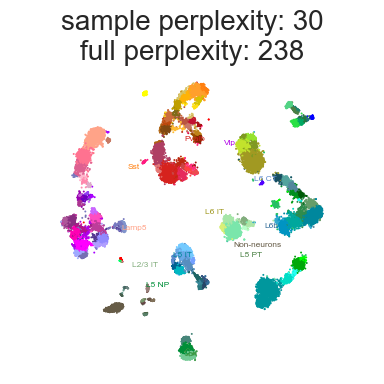

In [10]:
# to add or remove the title, change in the plot_embeddings function
figure = plot_embeddings(results, tasic2018)

# save the figure
file_name_timestamp = datetime.now().strftime("%H-%M-%S")
filename = f"tasic_without_metrics~_{file_name_timestamp}.png"
save_fig(figure, "tasic", filename, overwrite=True)

Figure saved to c:\Users\arsla\my_files\research_project\mg-emb-exps-main-KB-2\mg-emb-exps-main-KB\src\figures\multi-grid\fast_tsne\tasic\22-06-25\tasic_with_metrics~_05-49-31.png


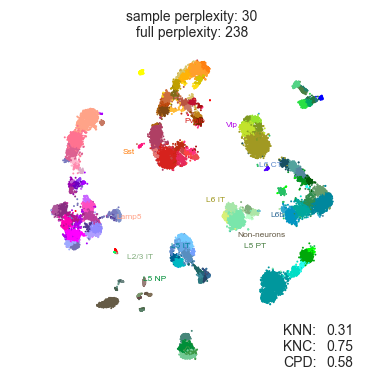

In [22]:
# to add or remove the title, change in the plot_embeddings function
figure_metrics = plot_embedding_with_metrics(results, tasic2018)

# save the figure
file_name_timestamp = datetime.now().strftime("%H-%M-%S")
filename = f"tasic_with_metrics~_{file_name_timestamp}.png"
save_fig(figure_metrics, "tasic", filename, overwrite=True)

#### Generate csv file containing cpd values between embeddings across the rows and save the file

In [ ]:
# Create and save the raw (long-form) CSV
cpd_df = pd.DataFrame(cpd_between_embeddings_records)

# Construct save path as per `save_fig`
folder_timestamp = datetime.now().strftime("%d-%m-%y")

cpd_dir = Path.cwd() / "figures" / "multi-grid" / "fast_tsne" / "tasic" / folder_timestamp
cpd_dir.mkdir(parents=True, exist_ok=True)
# Filename and save
cpd_filename = f"tasic_cpd_longform_{datetime.now().strftime('%H-%M-%S')}.csv"
cpd_path = cpd_dir / cpd_filename
cpd_df.to_csv(cpd_path, index=False)
print(f"Saved CPD (long-form) to {cpd_path}")

#### Plot embedding quality for each individual embedding across the rows

In [ ]:
import pandas as pd

# Convert results into a DataFrame for easy grouping and plotting
df_results = pd.DataFrame(results)

# For each unique sample_perplexity, plot metrics vs full_perplexity
for sample_perp in df_results['sample_perplexity'].unique():
    subset = df_results[df_results['sample_perplexity'] == sample_perp].sort_values(by="full_perplexity")

    fig = plt.figure(figsize=(10, 6))
    plt.plot(subset['full_perplexity'], subset['mnn'], marker='o', label='kNN')
    plt.plot(subset['full_perplexity'], subset['knc'], marker='s', label='KNC')
    plt.plot(subset['full_perplexity'], subset['cpd'], marker='^', label='CPD')

    plt.title(f"Sample Perplexity: {sample_perp}", fontsize=18)
    # plt.title("")
    plt.xlabel("Full Perplexity", fontsize=18)
    plt.ylabel("Metric Value", fontsize=18)

    plt.xticks(fontsize=18)  # <-- tick label font size for x-axis
    plt.yticks(fontsize=18)  # <-- tick label font size for y-axis
    plt.ylim(0, 1.05)
    plt.grid(True)
    plt.legend(fontsize=13)
    plt.tight_layout()
    plt.show()

    metric_plot_filename = f"quality_metrics_sampleperp_{sample_perp}.png"
    save_fig(fig, "tasic", metric_plot_filename)
    print(f"Saved metric plot as {metric_plot_filename}")

#### Plot embedding quality for each individual embedding across the columns

In [ ]:
for full_perp in df_results['full_perplexity'].unique():
    subset = df_results[df_results['full_perplexity'] == full_perp].sort_values(by="sample_perplexity")

    fig = plt.figure(figsize=(10, 6))
    plt.plot(subset['sample_perplexity'], subset['mnn'], marker='o', label='kNN')
    plt.plot(subset['sample_perplexity'], subset['knc'], marker='s', label='KNC')
    plt.plot(subset['sample_perplexity'], subset['cpd'], marker='^', label='CPD')

    plt.title(f"Full Perplexity: {full_perp}", fontsize=18)
    plt.xlabel("Sample Perplexity", fontsize=18)
    plt.ylabel("Metric Value", fontsize=18)

    plt.xticks(fontsize=18)  # <-- tick label font size for x-axis
    plt.yticks(fontsize=18)  # <-- tick label font size for y-axis

    plt.ylim(0, 1.05)
    plt.grid(True)
    plt.legend(fontsize=13)
    plt.tight_layout()
    plt.show()

    metric_plot_filename = f"quality_metrics_fullperp_{full_perp}.png"
    save_fig(fig, "tasic", metric_plot_filename)
    print(f"Saved metric plot as {metric_plot_filename}")


## Run t-SNE column wise

In [ ]:
sample_rate = 0.1

# tasic
# sample_perplexities = [10, 30, 100, 300, 1000]
# full_perplexities = [10, 30, 100, 300, 1000]
# test perplexities
sample_perplexities = [30]
full_perplexities = [238.2]


columnwise_results = []
embedding_reference_by_full_perp = {}
cpd_between_columns_records = []

for full_perp in full_perplexities:
    for sample_perp in sample_perplexities:

        print(f"Running for full_perp={full_perp}, sample_perp={sample_perp}...")

        # Run mg_tsne
        final_embedding = mg_tsne(
            initial_embedding=initial_embedding,
            sample_rate=sample_rate,
            sample_perplexity=sample_perp,
            full_perplexity=full_perp,
            rnd_state=42
        )

        # Evaluate quality metrics
        mnn, mnn_global, rho = embedding_quality(
            X=initial_embedding,
            Z=final_embedding,
            classes=labels,
            knn=10,
            knn_classes=4,
            subsetsize=1000
        )

        # Subsample for CPD
        subset_indices = np.random.choice(final_embedding.shape[0], size=1000, replace=False)
        emb_subset = final_embedding[subset_indices, :]
        cpd_value = None

        if full_perp not in embedding_reference_by_full_perp:
            embedding_reference_by_full_perp[full_perp] = emb_subset
        else:
            ref_embedding = embedding_reference_by_full_perp[full_perp]
            d1 = pdist(ref_embedding)
            d2 = pdist(emb_subset)
            cpd_value = spearmanr(d1, d2).correlation

            cpd_between_columns_records.append({
                "full_perplexity": full_perp,
                "sample_perplexity": sample_perp,
                "cpd_value": cpd_value
            })

        columnwise_results.append({
            "sample_perplexity": sample_perp,
            "full_perplexity": full_perp,
            "embedding": final_embedding,
            "labels": labels,
            "mnn": mnn,
            "knc": mnn_global,
            "cpd": rho
        })

        print("Done\n\n")



#### Generate csv file containing cpd values between embeddings across the columns and save the file

In [ ]:
# Convert to DataFrame
cpd_col_df = pd.DataFrame(cpd_between_columns_records)

# Save CSV
from datetime import datetime
from pathlib import Path

folder_timestamp = datetime.now().strftime("%d-%m-%y")
cpd_col_dir = Path.cwd() / "figures" / "multi-grid" / "fast_tsne" / "tasic" / folder_timestamp
cpd_col_dir.mkdir(parents=True, exist_ok=True)

cpd_col_filename = f"tasic_cpd_colwise_{datetime.now().strftime('%H-%M-%S')}.csv"
cpd_col_path = cpd_col_dir / cpd_col_filename
cpd_col_df.to_csv(cpd_col_path, index=False)
print(f"Saved CPD (column-wise) to {cpd_col_path}")